In [3]:
from google.colab import drive
dir=!ls
drive.mount("/content/gdrive")
import os

#os.chdir('/content/gdrive/My Drive/paper proyectos 2/Code/partialconv')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!ls

 data			     meta-data.zip		 train
 DL#+Beginner.zip	    'PConv Layer and UNET'	 train.zip
'image masker'		     __pycache__		 unetpconv2d.py
 image_maskgenerator.py      pytorch_to_keras_vgg16.h5	 vgg16.h5
 inpainting_notebook.ipynb   README.md
 InpaintingPC.ipynb	     test.zip


In [5]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 6.9MB/s 
  Created wheel for libarchive: filename=libarchive-0.4.7-cp36-none-any.whl size=31634 sha256=21292cece0ebeeb73fde55a49e5ad19e5fe4a51a7b8fc7fe3062a03853dd541c
  Stored in directory: /root/.cache/pip/wheels/3b/5c/fa/92ee330d259e8fa5bedbd53f67040710fe81cfa463b8711d26
Successfully built libarchive


In [6]:
!cp /'content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC/PConv Layer and UNET'/unetpconv2d.py ./
from unetpconv2d import PConvUNET

In [7]:
!cp /'content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC/image masker'/image_maskgenerator.py ./
from image_maskgenerator import MaskGenerator

In [8]:
!cp /'content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC/image masker'/pytorch_to_keras_vgg16.h5 ./

cp: cannot stat '/content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC/image masker/pytorch_to_keras_vgg16.h5': No such file or directory


In [ ]:
!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/DL%23+Beginner.zip

--2020-12-29 08:20:42--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/DL%23+Beginner.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.164.94
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.164.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6873530111 (6.4G) [application/zip]
Saving to: ‘DL#+Beginner.zip’

DL#+Beginner.zip    100%[===================>]   6.40G  12.8MB/s    in 8m 41s  

2020-12-29 08:29:24 (12.6 MB/s) - ‘DL#+Beginner.zip’ saved [6873530111/6873530111]



In [ ]:
!7z e DL#+Beginner.zip
!7z x train.zip
#!7z x test.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 6873530111 bytes (6556 MiB)

Extracting archive: DL#+Beginner.zip

ERRORS:
Headers Error

--
Path = DL#+Beginner.zip
Type = zip
ERRORS:
Headers Error
Physical Size = 6873530111
64-bit = +

  0%      0% 1 - DL# Beginner/test.zip                                1% 1 - DL# Beginner/test.zip                                2% 1 - DL# Beginner/test.zip                                3% 1 - DL# Beginner/test.zip                                4% 1 - DL# Beginner/test.zip

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import numpy as np
path = np.array(glob.glob('train/*.jpg'))
p = glob.glob('train/*.jpg')
#test_path = glob.glob('test/*.jpg')

In [10]:
from sklearn.model_selection import train_test_split
train,val,_,_ = train_test_split(path,path,test_size=0.2)
len(val)

2600

Generador de datos de imagen

In [11]:
from keras.utils import Sequence
import math
import numpy as np
import copy

class Data_Generator(Sequence):
    
    def __init__(self,x_path,batch_size=4,mode='train'):
        
        self.path = x_path
        self.batch_size = batch_size
        self.size=len(x_path)
        self.mode = mode
        
    def __getitem__(self,idx):
        
        start = idx*self.batch_size
        end = min((idx+1)*self.batch_size, self.size)
        
        x=[]
        mask=[]
        y=[]
        
        for i in range(start,end):
            im = cv2.imread(str(self.path[i]))
            im = cv2.resize(im,(512,512))
            im = im/255
            #print(im.dtype)
            
            
            m=MaskGenerator(im,0.02)
            m.masker()
            M = m.mask
            #print(M.dtype)
            
            if self.mode == 'train' :
                #random-crop
                p,q = np.random.randint(0,256,2)
                im1 = cv2.resize(im[p:p+256,q:q+256],(512,512))
                mask1 = cv2.resize(M[p:p+256,q:q+256],(512,512))
                mask.append(mask1)
                y.append(im1)
                im1 = copy.deepcopy(im1)
                im1[mask1==0] = 1
                x.append(im1)
                            
                #zooming
                zoom_factor = 2
                rows = 512
                cols = 512
                u = int(rows/(zoom_factor*2))
                v = int(cols/(zoom_factor*2))
                i = im[rows//2-u:rows//2+u,cols//2-v:cols//2+v]
                mask2 = M[rows//2-u:rows//2+u,cols//2-v:cols//2+v]
                mask2 = cv2.resize(mask2,(512,512))
                zoom_i = cv2.resize( i ,(512,512))
                mask.append(mask2)
                y.append(zoom_i)
                zoom_i = copy.deepcopy(zoom_i)
                zoom_i[mask2==0] = 1
                x.append(zoom_i)
                #plt.imshow(im)
    
                
                #Horizontal flipping
                img3 = np.fliplr(im)
                mask3 = np.fliplr(M)
                y.append(img3)
                mask.append(mask3)
                img3 = copy.deepcopy(img3)
                img3[mask3==0] = 1
                x.append(img3)
                #plt.imshow(im)
                
                #Random-rotation
                degrees = np.random.randint(0,45)
                r = cv2.getRotationMatrix2D((cols/2,rows/2),degrees,1)
                img4  = cv2.warpAffine(im,r,(cols,rows))
                mask4 = cv2.warpAffine(M,r,(cols,rows))
                img4 = cv2.resize( img4 ,(512,512))
                mask4 = cv2.resize(mask4 ,(512,512))
                #plt.imshow(img4)
                y.append(img4)
                mask.append(mask4)
                img4 = copy.deepcopy(img4)
                img4[mask4==0]=1
                x.append(img4)

            
            
            y.append(im)
            im = copy.deepcopy(im)
            im[M==0] = 1
            mask.append(M)
            x.append(im)
            
        x    = np.array(x)
        mask = np.array(mask)
        y    = np.array(y)
        return [x,mask],y 
            
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

In [12]:
traingen = Data_Generator(train,1)
valgen   = Data_Generator(val,2,'val')
x,y = traingen.__getitem__(1)

In [13]:
y.shape

(5, 512, 512, 3)

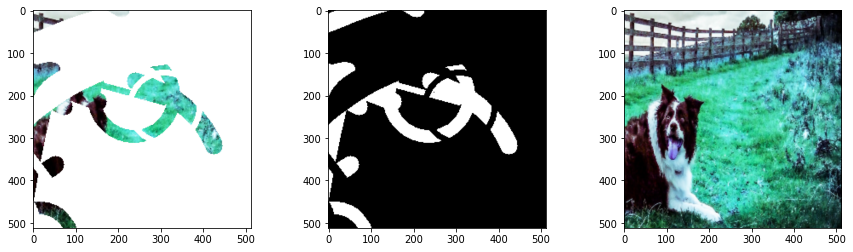

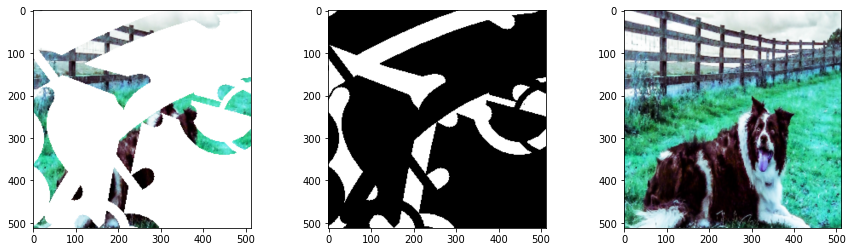

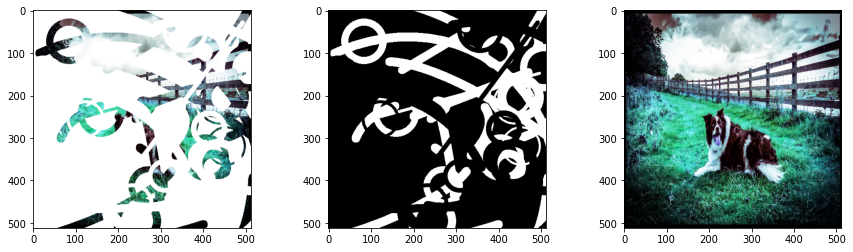

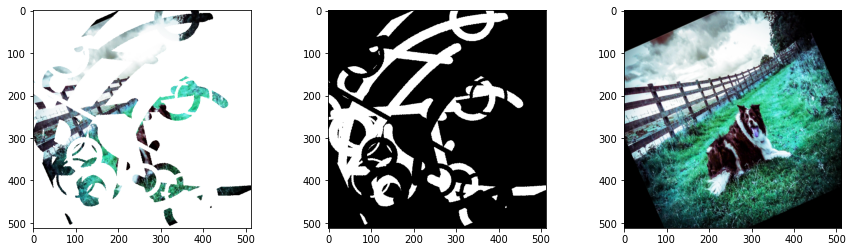

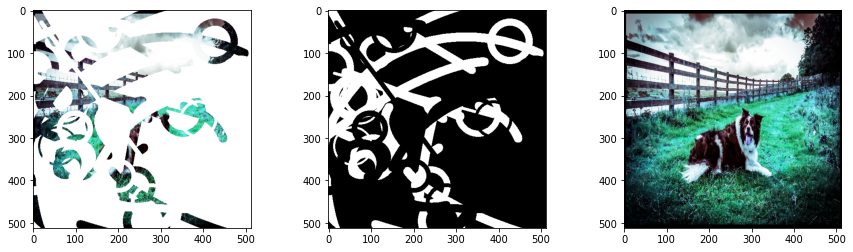

In [14]:
for i in range(5):
    _, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(x[0][i])
    axes[1].imshow(x[1][i]*1.)
    axes[2].imshow(y[i,:,:,:])
    plt.show()

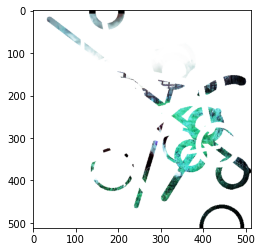

In [15]:
gen = Data_Generator(np.array([train[1]]),1)
x,y = gen.__getitem__(0)
plt.imshow(x[0][4])

In [16]:
!ls

 data			     meta-data.zip		 train
 DL#+Beginner.zip	    'PConv Layer and UNET'	 train.zip
'image masker'		     __pycache__		 unetpconv2d.py
 image_maskgenerator.py      pytorch_to_keras_vgg16.h5	 vgg16.h5
 inpainting_notebook.ipynb   README.md
 InpaintingPC.ipynb	     test.zip


In [ ]:
img_rows    = 512
img_columns = 512
channels    = 3

model = PConvUNET(img_rows,
                  img_columns,
                  channels,
                  weights='/content/gdrive/My Drive/Colab Notebooks/Image-Inpainting-PC/pytorch_to_keras_vgg16.h5')

model.model,model.masks=model.build_pconv_UNet(train_bn=False)
model.model_compile(model.model,model.masks,lr=1e-5)
model_json = model.to_json()

IndexError: ignored

In [ ]:
!cp gdrive/'My Drive'/Best-weights-my_model-003-3.7744-15.6183.hdf5 ./
model.model.load_weights('Best-weights-my_model-003-3.7744-15.6183.hdf5')
#/content/gdrive/My Drive/Best-weights-my_model-001-5.4188-14.4929.hdf5

cp: cannot stat 'gdrive/My Drive/Best-weights-my_model-003-3.7744-15.6183.hdf5': No such file or directory


NameError: ignored